In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [2]:
device = "cuda" if torch.cuda.is_available() else "mps"
device

'mps'

In [3]:
# Set seeds
def set_seeds(seed: int=42):
    """ Sets random seeds for torch operations
    Args: 
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [4]:
import os
import zipfile
from pathlib import Path
import requests

def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.
    Args:
        source (str): A link to a zipped file containing data
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.

    Returns: 
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
        destination="pizza_steak_sushi"))
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [5]:
# Set up directories
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup ImageNet normalization levels (turns all images into similar distribution as ImageNet)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])
print(f"Manually created transforms: {manual_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x17875e090>,
 ['pizza', 'steak', 'sushi'])

In [6]:
# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup pretrained weights (plenty of these available in torchvision.models)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms from weights (these are the transforms that were used to obtain the weights)
automatic_transforms = weights.transforms()
print(f"Automatically created transforms: {automatic_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms, # use automatic created transforms
    batch_size=32
)
train_dataloader, test_dataloader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x1787abfd0>,
 ['pizza', 'steak', 'sushi'])

In [7]:
# Download the pretrained weights for EfficientNet_B0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # NEW in torchvision 0.13, "DEFAULT" means "best weights available"

# Setup the model with the pretrained weights and send it to the target device
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

# View the output of the model
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [8]:
# Freeze all base layers by setting requires_grad attribute to False
for param in model.features.parameters():
    param.requires_grad = False

# Since we're creating a new layer with random weights (torch.nn.Linear),
# let's set the seeds
set_seeds()

# Update the classifier head to suit our problem
model.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names),
              bias=True).to(device)
)

In [9]:
from torchinfo import summary

# Get a summary of the model 
summary(model,
        input_size=(32, 3, 224, 224), 
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"], 
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [10]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
from torch.utils.tensorboard import SummaryWriter

# Create a writer with all default settings
writer = SummaryWriter()

In [12]:
from typing import Dict, List
from tqdm.auto import tqdm

from going_modular.going_modular.engine import train_step, test_step
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model
    
    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout

    Args:
        model: A PyTorch model to be trained and tested
        train_dataloader: A DataLoader instance for the model to be trained on
        test_dataloader: A DataLoader instance for the model to be tested
        optimizer: A PyTorch optimizer to help minimize the loss function
        loss_fn: A PyTorch loss function to calculate loss on both datasets
        epochs: An integer indicating how many epochs to train for.
        device: A target device to compute on (e.g. "cuda" or "cpu")
    
    Returns:
        A dictionary of traning and testing loss as well as training and testing accuracy metrics. 
        Each metric has a value in a list for each epoch.
        In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """

    # Create empty results dictionary
    results = {"train_loss": [], 
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model.to(device),
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model.to(device),
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        
        # Print out what's happening 
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### Experiment Tracking ### 
        # Add loss results to SummaryWriter
        writer.add_scalars(main_tag="Loss",
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss":test_loss},
                           global_step=epoch)
        # Add accuracy results to SummaryWriter
        writer.add_scalars(main_tag="Accuracy",
                           tag_scalar_dict={"train_acc": train_acc, 
                                            "test_acc": test_acc},
                           global_step=epoch)
        # Track the PyTorch model architecture
        writer.add_graph(model=model,
                         # Pass in an example input
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))
        
    # Close the writer
    writer.close()

    # Return the filled results at the end of the eopchs
    return results


In [13]:
# Train Model
set_seeds()
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device="mps")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0852 | train_acc: 0.3906 | test_loss: 0.8992 | test_acc: 0.6108
Epoch: 2 | train_loss: 0.9262 | train_acc: 0.6758 | test_loss: 0.7939 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7893 | train_acc: 0.7383 | test_loss: 0.6808 | test_acc: 0.8968
Epoch: 4 | train_loss: 0.7031 | train_acc: 0.8398 | test_loss: 0.6807 | test_acc: 0.8248
Epoch: 5 | train_loss: 0.7073 | train_acc: 0.7109 | test_loss: 0.6926 | test_acc: 0.7131


In [14]:
def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str = None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """
        Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.
        log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.
        Where timestamp is the current date in YYYY-MM-DD format

        Args: 
            experiment_name (str): Name of experiment.
            model_name (str): Name of model.
            extra (str, optional): Anything extra to add to the directory. Defaults to None.

        Returns:
            torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

        Example usage:
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-mm-DD format
    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)



In [15]:
# Create an example writer
example_writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb0",
                               extra="5_epochs")

[INFO] Created SummaryWriter, saving to: runs/2024-04-14/data_10_percent/effnetb0/5_epochs...


In [16]:
from typing import Dict, List
from tqdm.auto import tqdm

# Add writer parameter to train()
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device, 
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

In [18]:
from torchvision import transforms
# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
# Compose transforms in to a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Resize the images
    transforms.ToTensor(), # 2. Turn the images into tensors with values between 0 & 1
    normalize # 3. Normalize the images so their distributions match the ImageNet dataset
])

In [20]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

[INFO] data/pizza_steak_sushi directory exists, skipping download.
[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.
Training directory 10%: data/pizza_steak_sushi/train
Training directory 20%: data/pizza_steak_sushi_20_percent/train
Testing directory: data/pizza_steak_sushi/test


In [21]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
    test_dir=test_dir, 
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Create 20% training and test data DataLoders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(train_dataloader_10_percent)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 8 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


In [25]:
import torchvision
from torchinfo import summary

# 1. Create an instance of EffNetB2 with pretrained weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" means best available weights
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# # 2. Get a summary of standard EffNetB2 from torchvision.models (uncomment for full output)
summary(model=effnetb2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

# 3. Get the number of in_features of the EfficientNetB2 classifier layer
# print(f"Number of in_features to final layer of EfficientNetB2: {len(effnetb2.classifier.state_dict()['1.weight'][0])}")

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [26]:
import torchvision
from torch import nn

# Get num out features (one for each class pizza, steak, sushi)
OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
    # 1. Get the base mdoel with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

# Create an EffNetB2 feature extractor
def create_effnetb2():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [27]:
effnetb0 = create_effnetb0() 

# Get an output summary of the layers in our EffNetB0 feature extractor model (uncomment to view full output)
summary(model=effnetb0, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

[INFO] Created new effnetb0 model.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### 7.6 Create experiments and set up training code

In [38]:
# Create epoch list
num_epochs = [5, 10]

# Create models list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb2"]

# Create a DataLoaders dictionary
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                    "data_20_percent": train_dataloader_20_percent}

In [41]:
%%time
from going_modular.going_modular.utils import save_model

# Set seeds
set_seeds(seed=42)

# Keep track of experiment numbers
experiment_number = 0

# Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():
    # Loop through the epochs
    for epochs in num_epochs:
        # Loop through each model name and create a new model instance
        for model_name in models:
            # Print out info
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] N epochs: {epochs}")

            # Select and create the model
            if model_name == "effnetb0":
                model = create_effnetb0()
            else:
                model = create_effnetb2()

            # Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            
            # Train target model with target dataloader and track experiments
            # Using trian instead of engine.train
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader,
                  loss_fn=loss_fn,
                  optimizer=optimizer,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))


            # Save the model to file so we can import it later if need be
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model, 
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")





[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] N epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2024-04-14/data_10_percent/effnetb0/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0619 | train_acc: 0.4766 | test_loss: 0.9217 | test_acc: 0.4877
Epoch: 2 | train_loss: 0.8727 | train_acc: 0.6445 | test_loss: 0.8282 | test_acc: 0.5900
Epoch: 3 | train_loss: 0.8235 | train_acc: 0.6289 | test_loss: 0.7198 | test_acc: 0.8456
Epoch: 4 | train_loss: 0.7102 | train_acc: 0.7617 | test_loss: 0.5876 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.6376 | train_acc: 0.8828 | test_loss: 0.5570 | test_acc: 0.8968
[INFO] Saving model to: models/07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] N epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2024-04-14/data_10_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0773 | train_acc: 0.3789 | test_loss: 0.9439 | test_acc: 0.7112
Epoch: 2 | train_loss: 0.9200 | train_acc: 0.6445 | test_loss: 0.8545 | test_acc: 0.8040
Epoch: 3 | train_loss: 0.8255 | train_acc: 0.7109 | test_loss: 0.7419 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.7239 | train_acc: 0.8516 | test_loss: 0.7093 | test_acc: 0.8977
Epoch: 5 | train_loss: 0.6664 | train_acc: 0.7812 | test_loss: 0.6994 | test_acc: 0.8665
[INFO] Saving model to: models/07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] N epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2024-04-14/data_10_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0619 | train_acc: 0.4766 | test_loss: 0.9217 | test_acc: 0.4877
Epoch: 2 | train_loss: 0.8727 | train_acc: 0.6445 | test_loss: 0.8282 | test_acc: 0.5900
Epoch: 3 | train_loss: 0.8235 | train_acc: 0.6289 | test_loss: 0.7198 | test_acc: 0.8456
Epoch: 4 | train_loss: 0.7090 | train_acc: 0.7617 | test_loss: 0.5871 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.6376 | train_acc: 0.8828 | test_loss: 0.5566 | test_acc: 0.8968
Epoch: 6 | train_loss: 0.5575 | train_acc: 0.9023 | test_loss: 0.5934 | test_acc: 0.8759
Epoch: 7 | train_loss: 0.5765 | train_acc: 0.8086 | test_loss: 0.5387 | test_acc: 0.8864
Epoch: 8 | train_loss: 0.4891 | train_acc: 0.9297 | test_loss: 0.4994 | test_acc: 0.8968
Epoch: 9 | train_loss: 0.6270 | train_acc: 0.7383 | test_loss: 0.4919 | test_acc: 0.9072
Epoch: 10 | train_loss: 0.4593 | train_acc: 0.9414 | test_loss: 0.4476 | test_acc: 0.9176
[INFO] Saving model to: models/07_effnetb0_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0734 | train_acc: 0.3711 | test_loss: 0.9483 | test_acc: 0.6610
Epoch: 2 | train_loss: 0.9195 | train_acc: 0.6367 | test_loss: 0.8536 | test_acc: 0.8040
Epoch: 3 | train_loss: 0.8275 | train_acc: 0.7148 | test_loss: 0.7403 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.7217 | train_acc: 0.8477 | test_loss: 0.7084 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.6667 | train_acc: 0.7734 | test_loss: 0.6986 | test_acc: 0.8362
Epoch: 6 | train_loss: 0.6157 | train_acc: 0.7695 | test_loss: 0.6248 | test_acc: 0.9176
Epoch: 7 | train_loss: 0.5898 | train_acc: 0.8047 | test_loss: 0.6116 | test_acc: 0.8759
Epoch: 8 | train_loss: 0.5438 | train_acc: 0.9180 | test_loss: 0.6024 | test_acc: 0.8873
Epoch: 9 | train_loss: 0.5257 | train_acc: 0.8281 | test_loss: 0.5817 | test_acc: 0.8873
Epoch: 10 | train_loss: 0.4855 | train_acc: 0.9102 | test_loss: 0.5608 | test_acc: 0.9280
[INFO] Saving model to: models/07_effnetb2_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9570 | train_acc: 0.5875 | test_loss: 0.6634 | test_acc: 0.8759
Epoch: 2 | train_loss: 0.7146 | train_acc: 0.8000 | test_loss: 0.5937 | test_acc: 0.8769
Epoch: 3 | train_loss: 0.5919 | train_acc: 0.8292 | test_loss: 0.4614 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5142 | train_acc: 0.8458 | test_loss: 0.4462 | test_acc: 0.9384
Epoch: 5 | train_loss: 0.5016 | train_acc: 0.8271 | test_loss: 0.3937 | test_acc: 0.9280
[INFO] Saving model to: models/07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] N epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2024-04-14/data_20_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9822 | train_acc: 0.5354 | test_loss: 0.7900 | test_acc: 0.8153
Epoch: 2 | train_loss: 0.7518 | train_acc: 0.7833 | test_loss: 0.6596 | test_acc: 0.9072
Epoch: 3 | train_loss: 0.6148 | train_acc: 0.8146 | test_loss: 0.5618 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.5612 | train_acc: 0.8292 | test_loss: 0.5640 | test_acc: 0.8570
Epoch: 5 | train_loss: 0.4687 | train_acc: 0.8562 | test_loss: 0.4502 | test_acc: 0.9176
[INFO] Saving model to: models/07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] N epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2024-04-14/data_20_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9570 | train_acc: 0.5875 | test_loss: 0.6634 | test_acc: 0.8759
Epoch: 2 | train_loss: 0.7146 | train_acc: 0.8000 | test_loss: 0.5937 | test_acc: 0.8769
Epoch: 3 | train_loss: 0.5919 | train_acc: 0.8292 | test_loss: 0.4614 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5142 | train_acc: 0.8458 | test_loss: 0.4462 | test_acc: 0.9384
Epoch: 5 | train_loss: 0.5016 | train_acc: 0.8271 | test_loss: 0.3937 | test_acc: 0.9280
Epoch: 6 | train_loss: 0.4043 | train_acc: 0.8917 | test_loss: 0.3664 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.3946 | train_acc: 0.8833 | test_loss: 0.3271 | test_acc: 0.9072
Epoch: 8 | train_loss: 0.3886 | train_acc: 0.8812 | test_loss: 0.3366 | test_acc: 0.9384
Epoch: 9 | train_loss: 0.3247 | train_acc: 0.9146 | test_loss: 0.3073 | test_acc: 0.9176
Epoch: 10 | train_loss: 0.3817 | train_acc: 0.8771 | test_loss: 0.2755 | test_acc: 0.9176
[INFO] Saving model to: models/07_effnetb0_data_20_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9825 | train_acc: 0.5354 | test_loss: 0.7893 | test_acc: 0.8153
Epoch: 2 | train_loss: 0.7526 | train_acc: 0.7729 | test_loss: 0.6587 | test_acc: 0.9072
Epoch: 3 | train_loss: 0.6161 | train_acc: 0.8125 | test_loss: 0.5614 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.5612 | train_acc: 0.8271 | test_loss: 0.5644 | test_acc: 0.8570
Epoch: 5 | train_loss: 0.4689 | train_acc: 0.8583 | test_loss: 0.4504 | test_acc: 0.9280
Epoch: 6 | train_loss: 0.4013 | train_acc: 0.9125 | test_loss: 0.4611 | test_acc: 0.8873
Epoch: 7 | train_loss: 0.3866 | train_acc: 0.9000 | test_loss: 0.4091 | test_acc: 0.9489
Epoch: 8 | train_loss: 0.3866 | train_acc: 0.8896 | test_loss: 0.4237 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.3363 | train_acc: 0.9104 | test_loss: 0.4125 | test_acc: 0.9081
Epoch: 10 | train_loss: 0.3690 | train_acc: 0.8958 | test_loss: 0.3895 | test_acc: 0.9081
[INFO] Saving model to: models/07_effnetb2_data_20_percent_10_epochs.pth
------------------------------------

# 9. Load the best model and making predictions

In [43]:
# Setup best model filepath
best_model_path = "models/07_effnetb2_data_20_percent_10_epochs.pth"

# Instantiate a new instance of EffNetB2 (to load in the saved state_dict())
best_model = create_effnetb2()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))



[INFO] Created new effnetb2 model.


<All keys matched successfully>

In [44]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert it to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024 * 1024)

print(f"EfficieNetB2 model size: {effnetb2_model_size} MB")



EfficieNetB2 model size: 29 MB


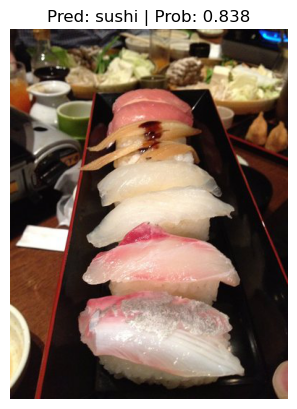

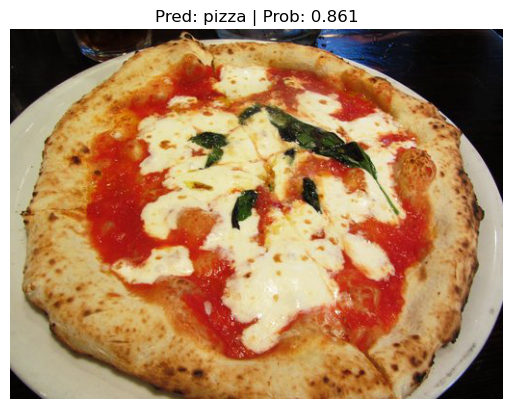

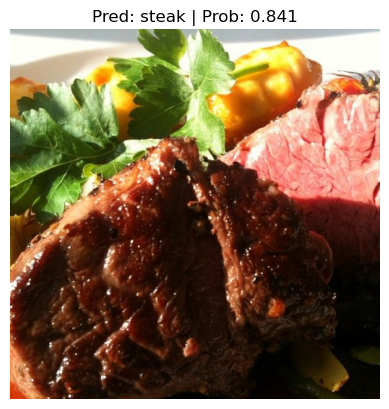

In [47]:
# Import function to make prediction on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Get a random list of 3 image path names from the test dataset
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list, 
                                       k=num_images_to_plot)
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model, 
                        image_path=image_path,
                        class_names=class_names, 
                        image_size=(224,224))